In [1]:
import itertools
import sys

import matplotlib.pyplot as plt

sys.path.append('..')
from antlia import lidar
from antlia import util

%load_ext autoreload
%autoreload 2

In [2]:
def set_title(ax, title):
    try:
        mpld3
    except NameError:
        ax.figure.suptitle(title)
    else:
        ax.set_title(title)
        
DEFAULT_FIGSIZE = (14, 7)

In [3]:
records = lidar.load_records(sync=True)

Unable to determine range 2
Unable to determine range 1


In [4]:
import numpy as np
from sklearn.cluster import KMeans

def bcp_brute(a, b):
    min_dist = np.inf
    min_a = None
    min_b = None
    for ai in a:
        for bi in b:
            d = np.sqrt((ai[0] - bi[0])**2 + (ai[1] - bi[1])**2)
            if d < min_dist:
                min_dist = d
                min_a = ai
                min_b = bi
    return min_dist, min_a, min_b

def cluster(x, y):
    try:
        x = x.compressed()
        y = y.compressed()
    except AttributeError:
        pass
    x = np.reshape(x, (-1,))
    y = np.reshape(y, (-1,))
    X = np.vstack((x, y)).transpose()
    
    kmeans = KMeans(2).fit(X)
    index0 = kmeans.labels_ == 0
    index1 = kmeans.labels_ == 1
    
    a = list(zip(x[index0], y[index0]))
    b = list(zip(x[index1], y[index1]))
    return a, b

/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


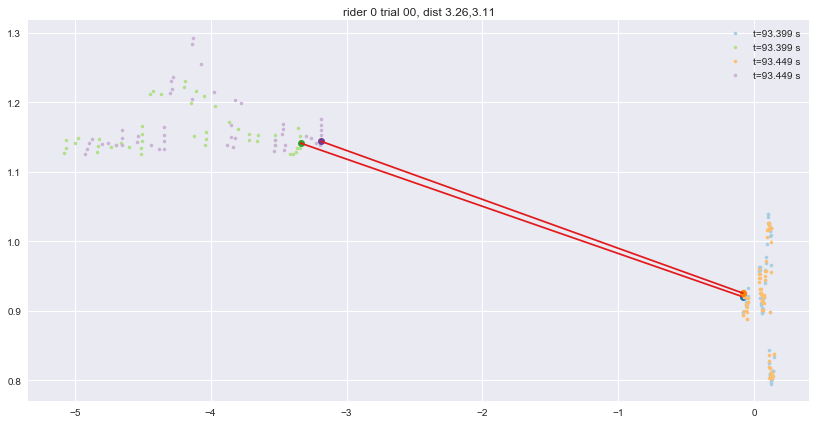

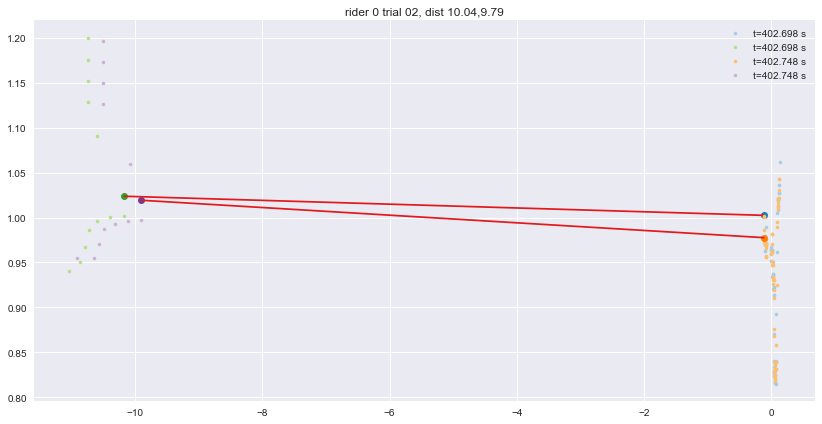

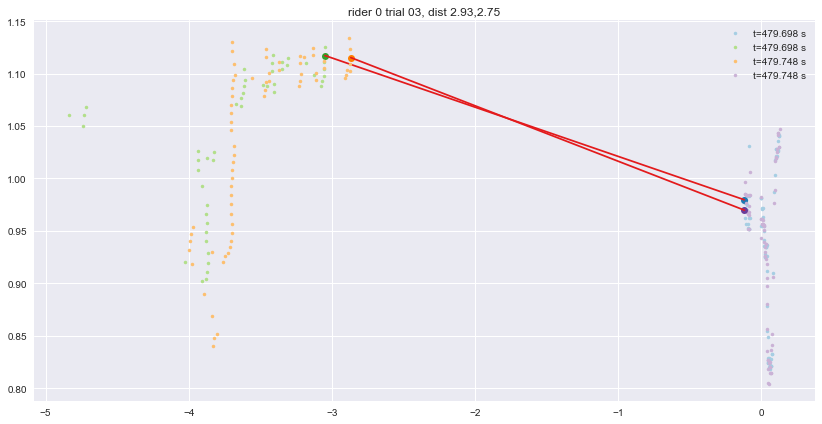

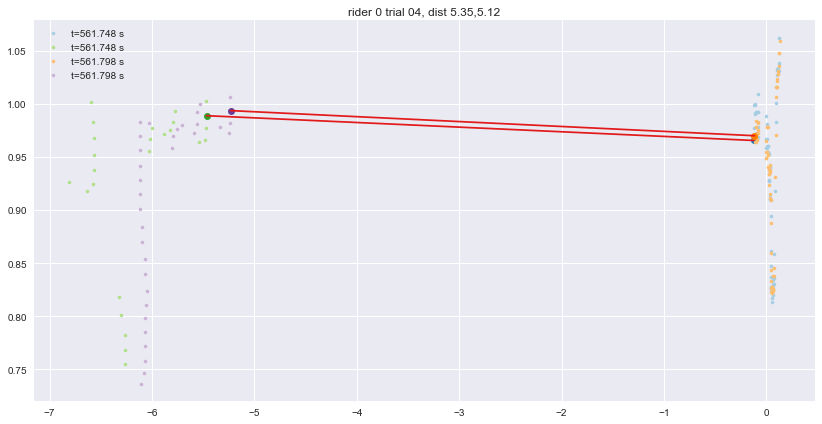

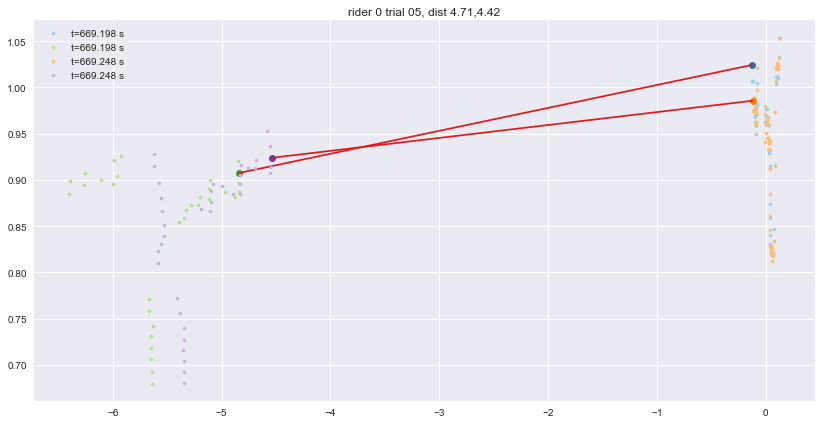

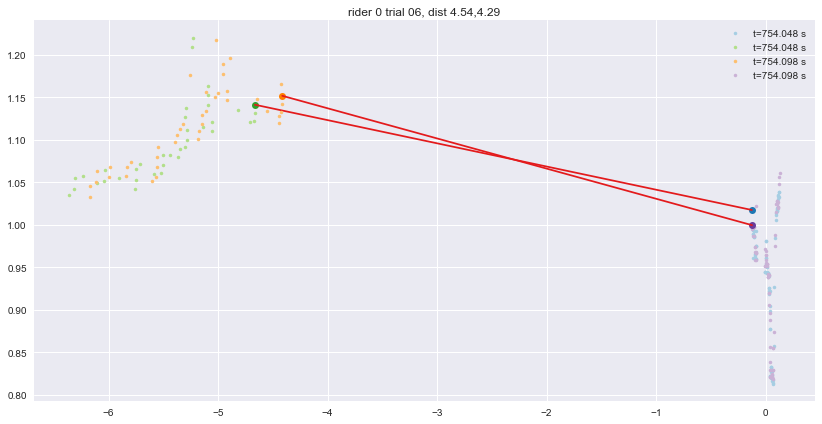

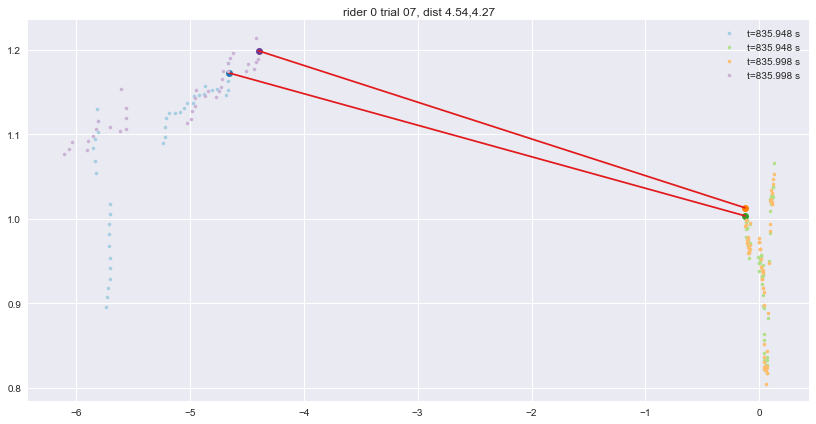

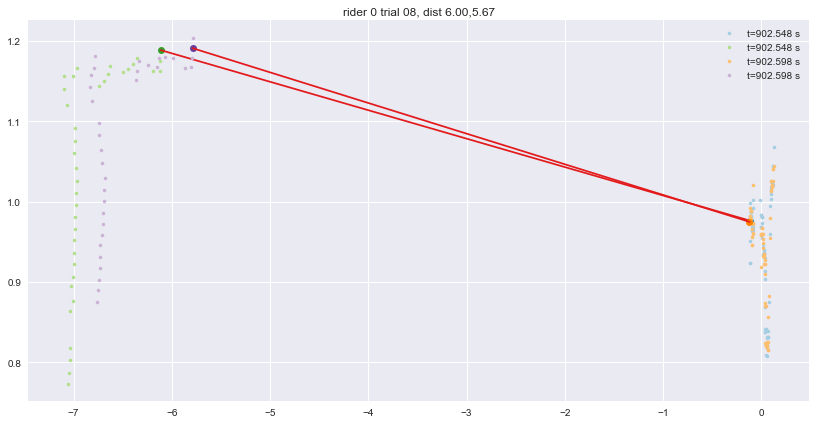

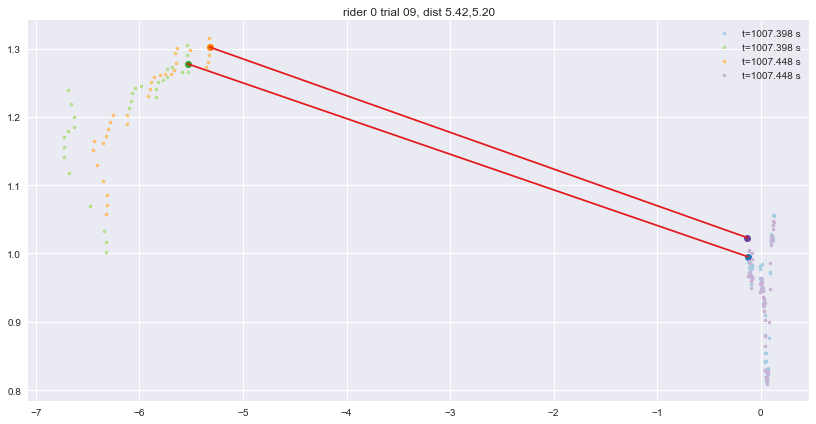

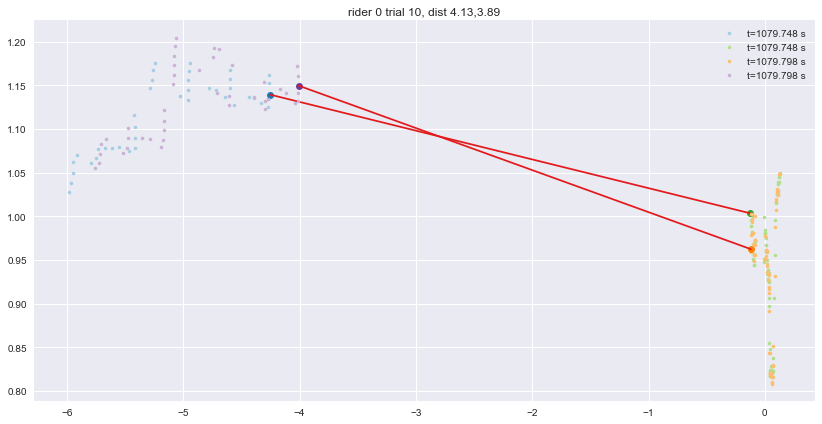

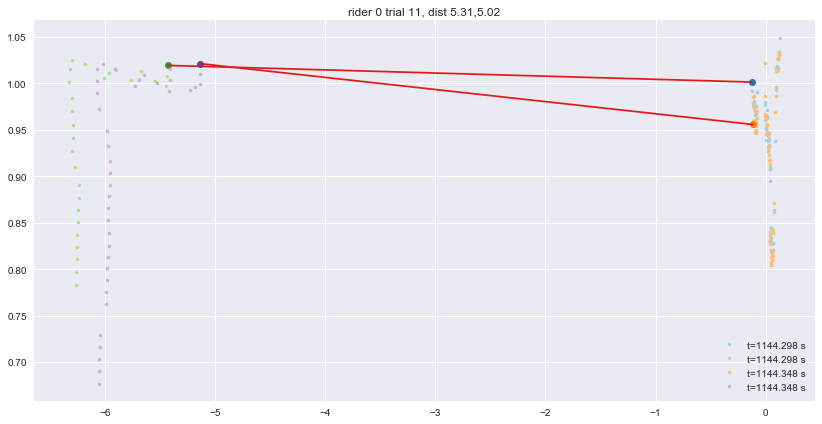

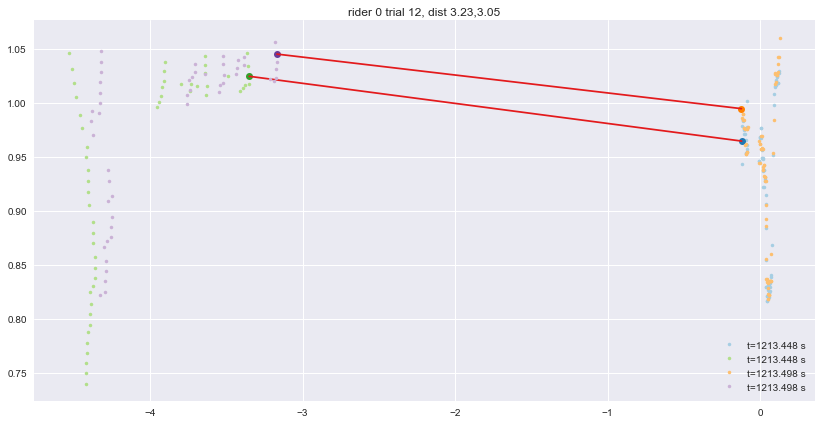

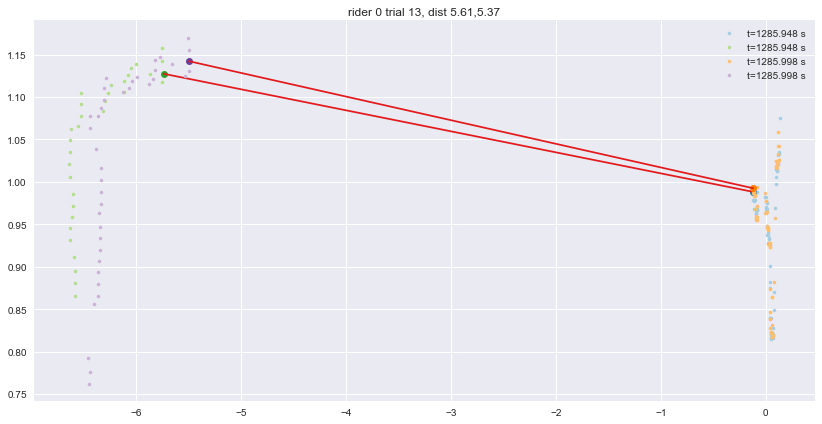

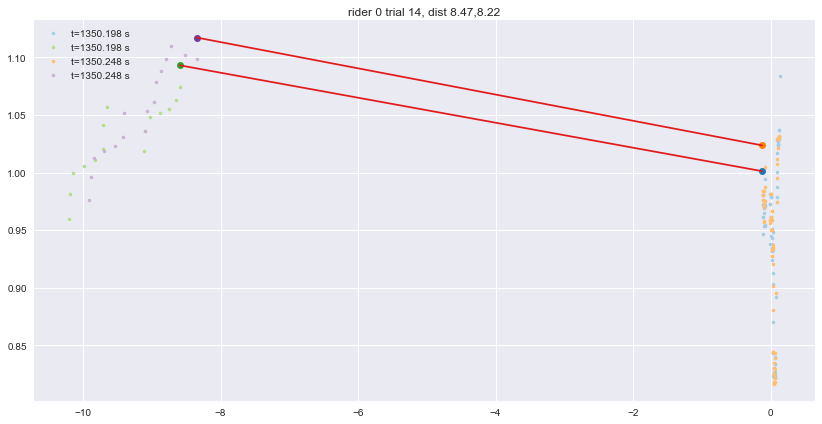

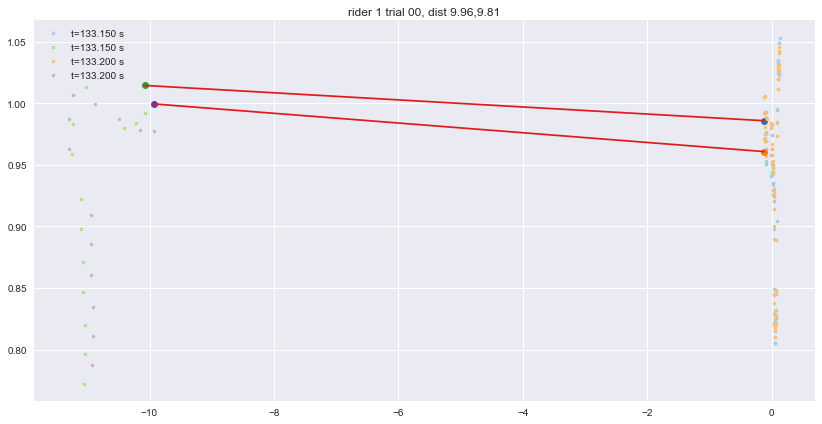

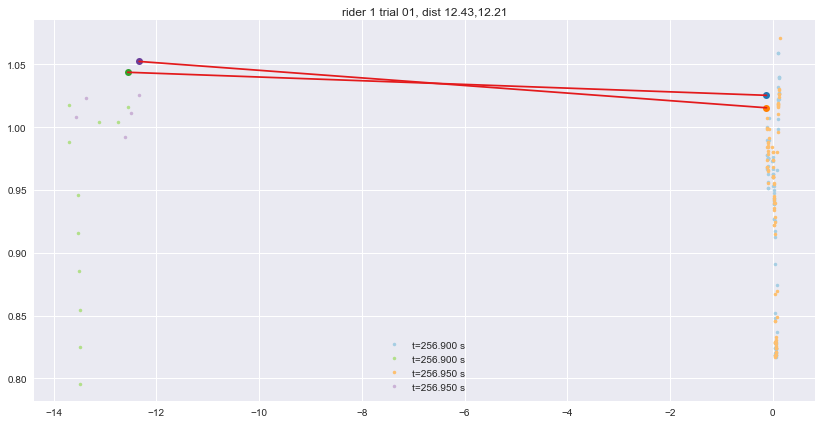

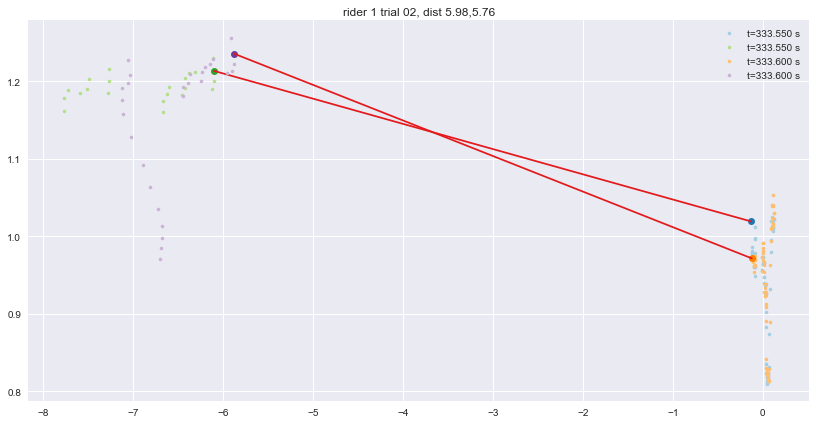

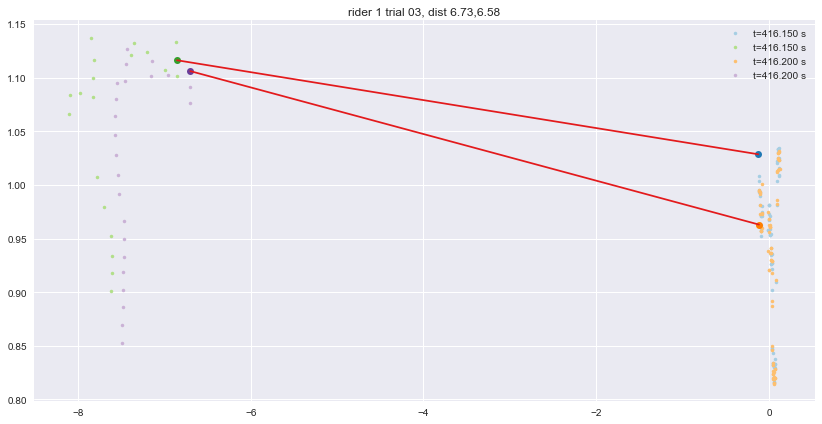

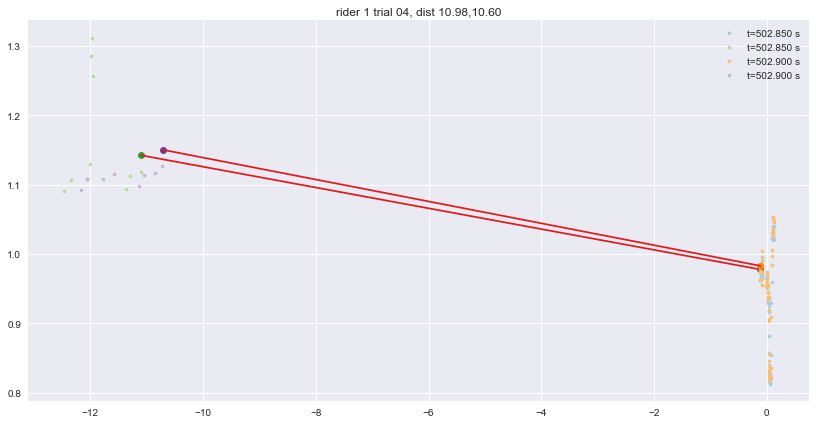

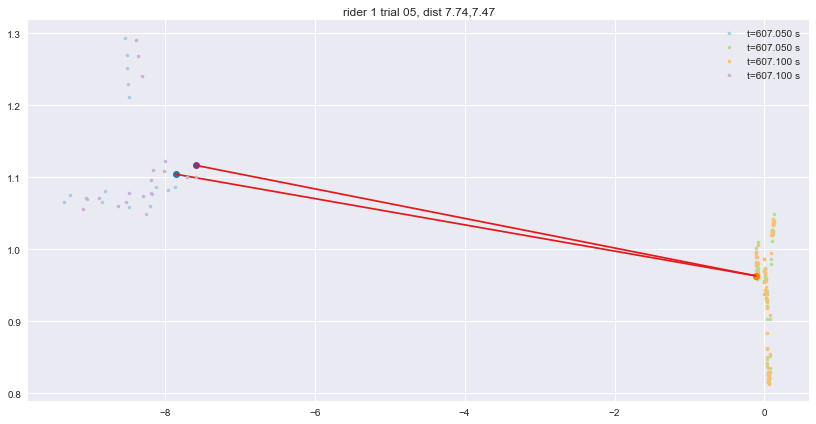

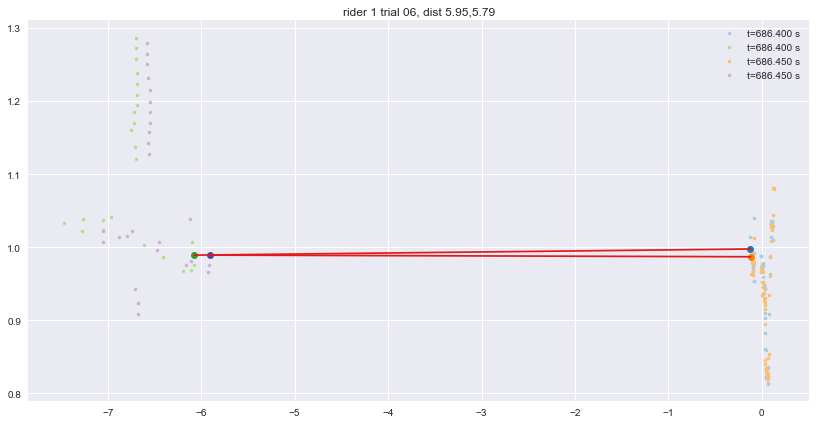

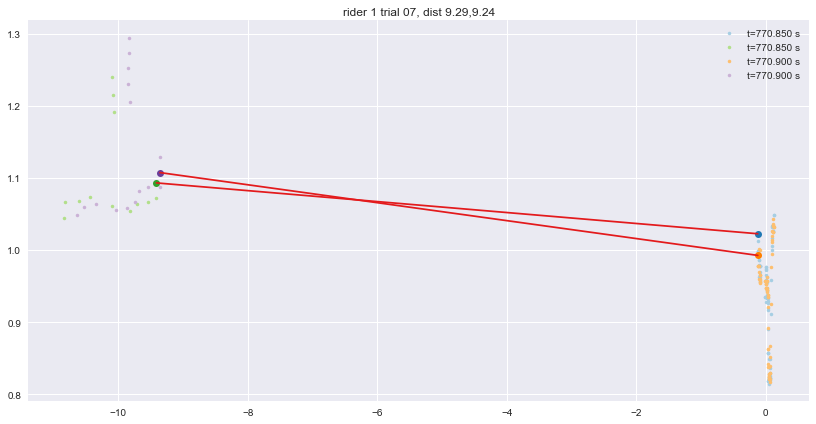

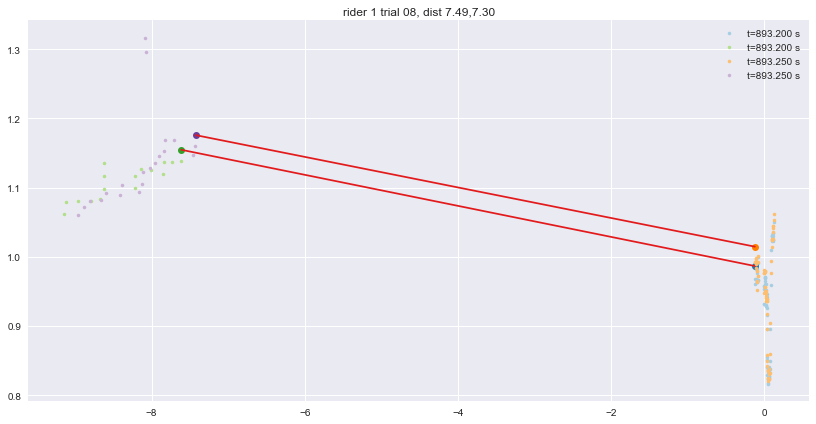

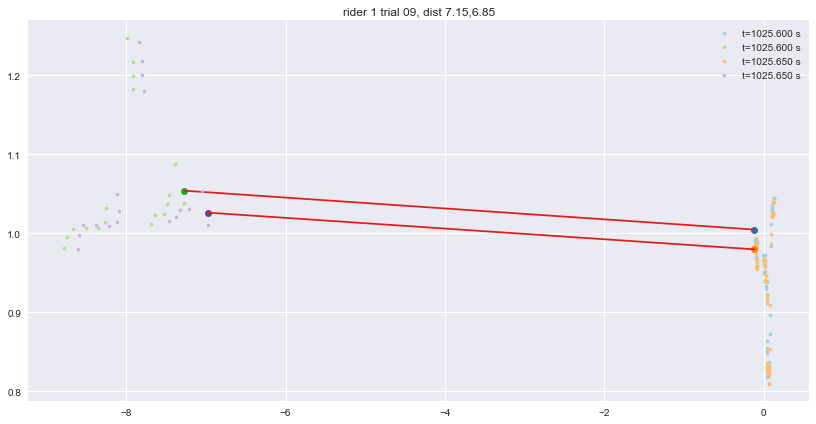

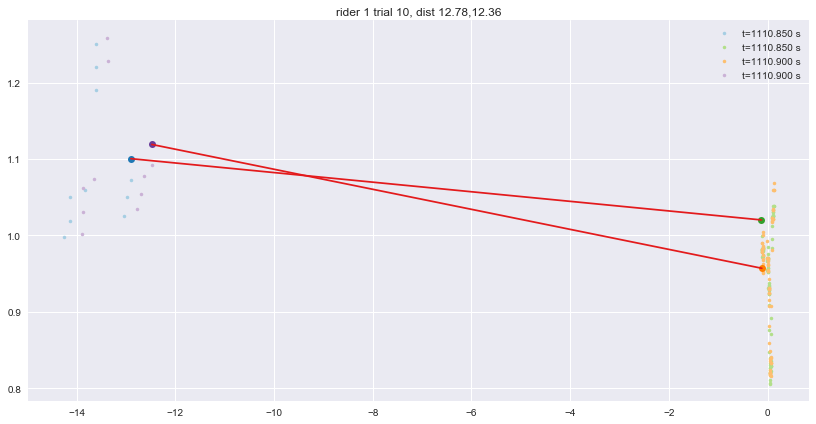

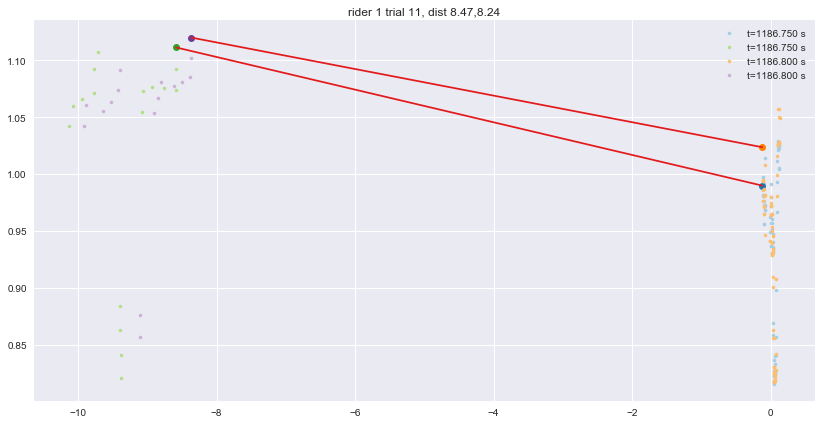

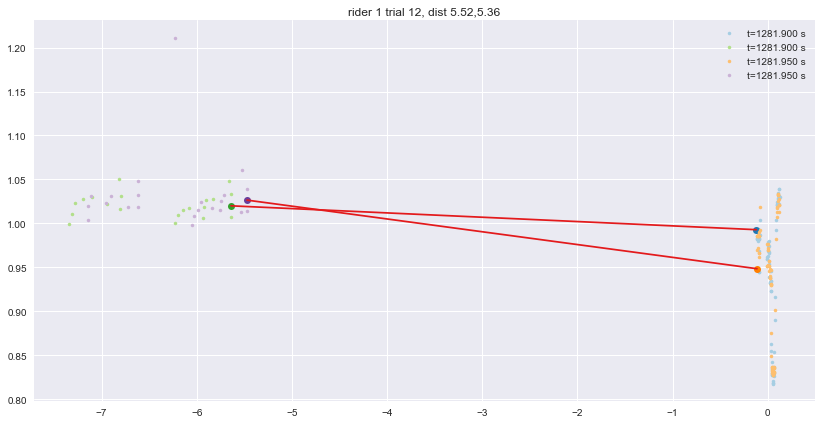

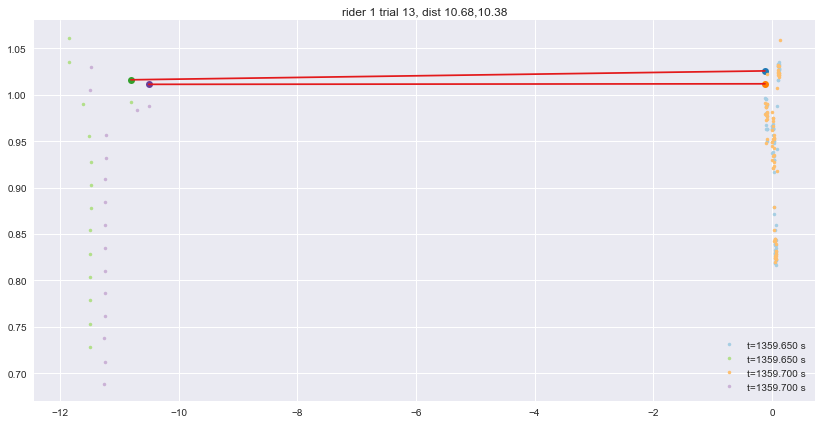

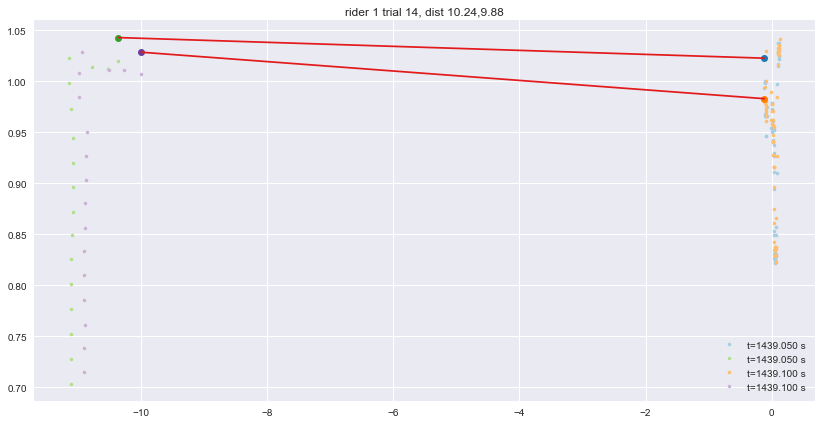

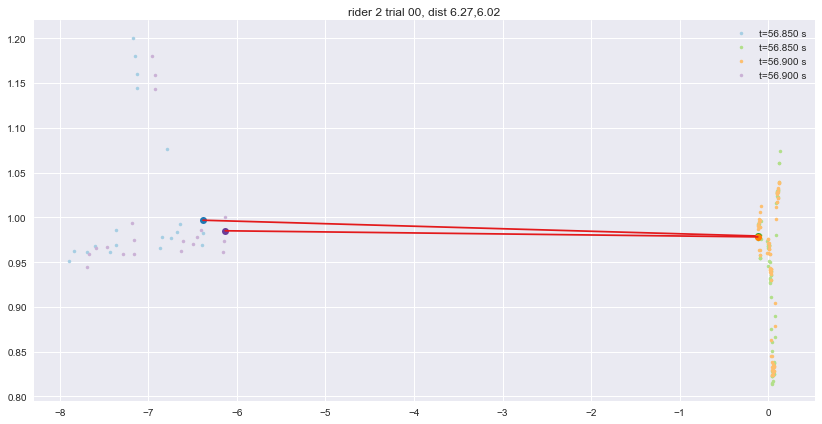

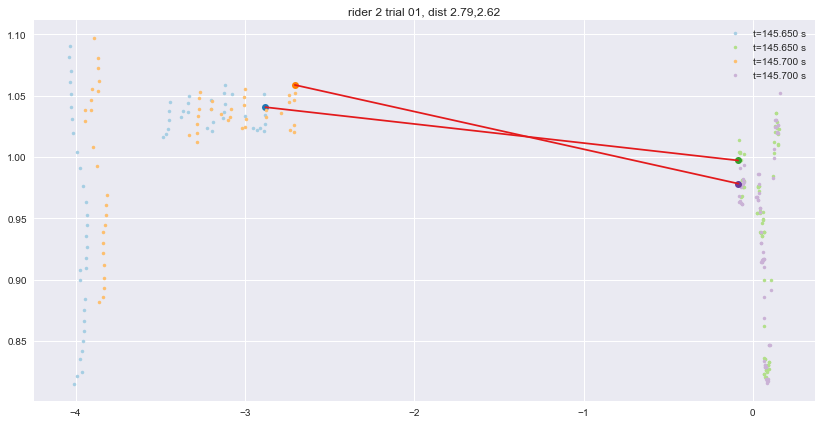

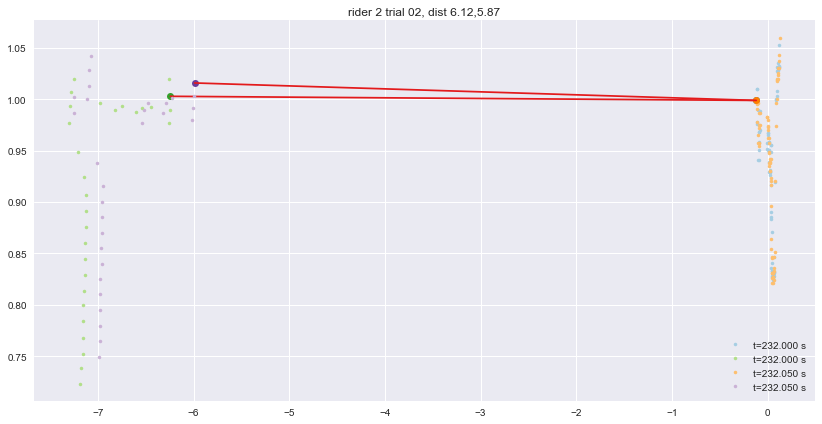

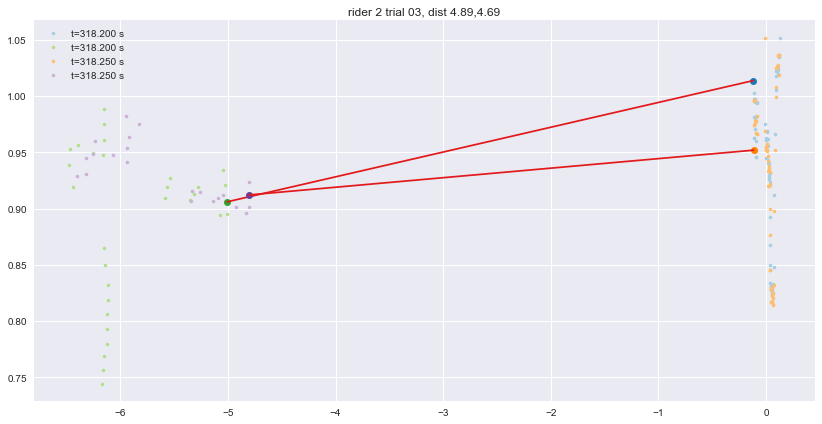

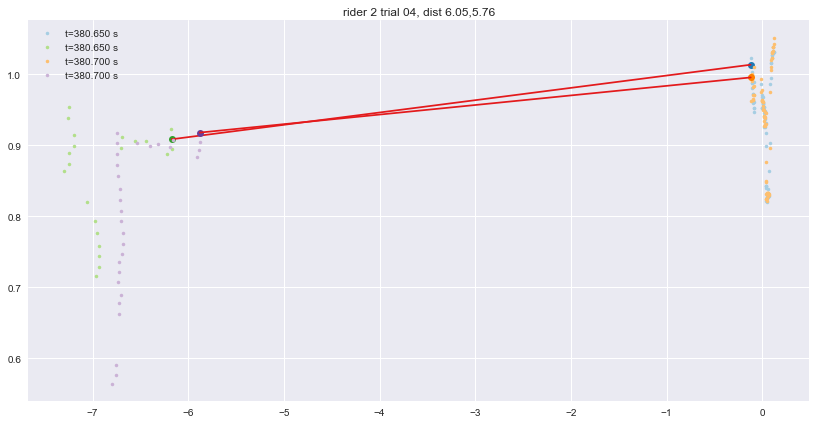

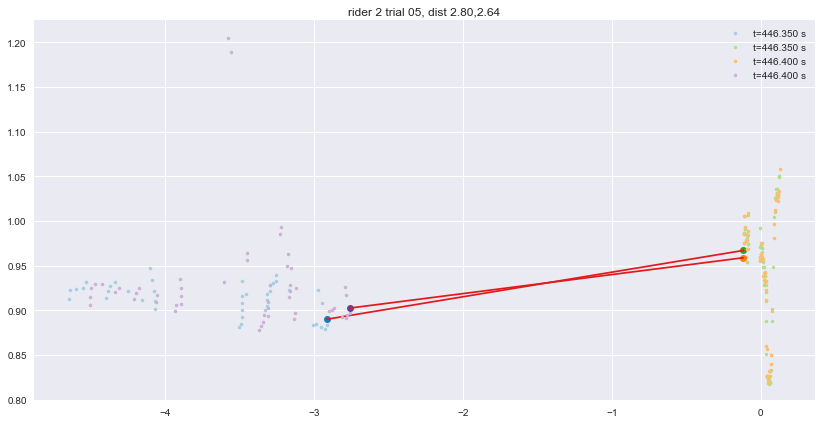

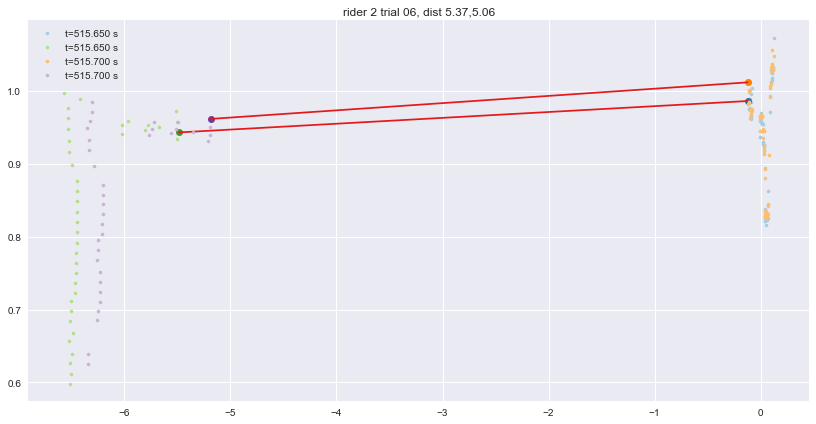

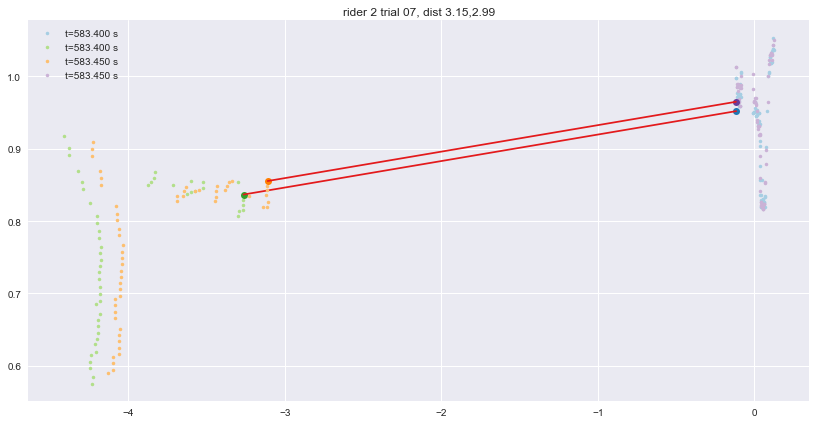

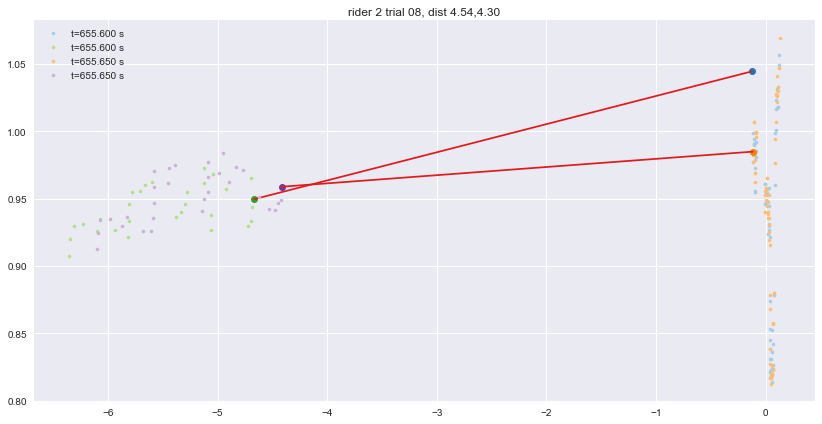

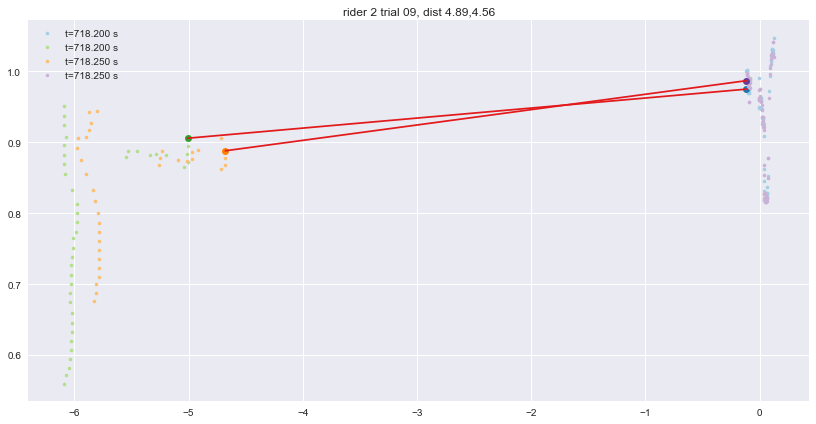

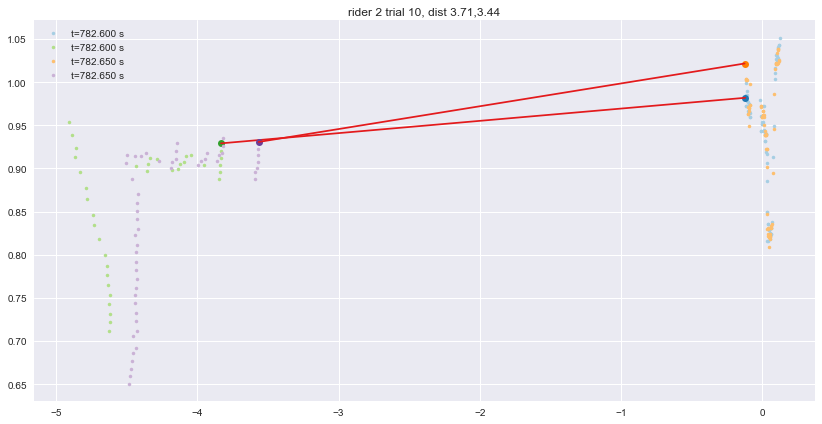

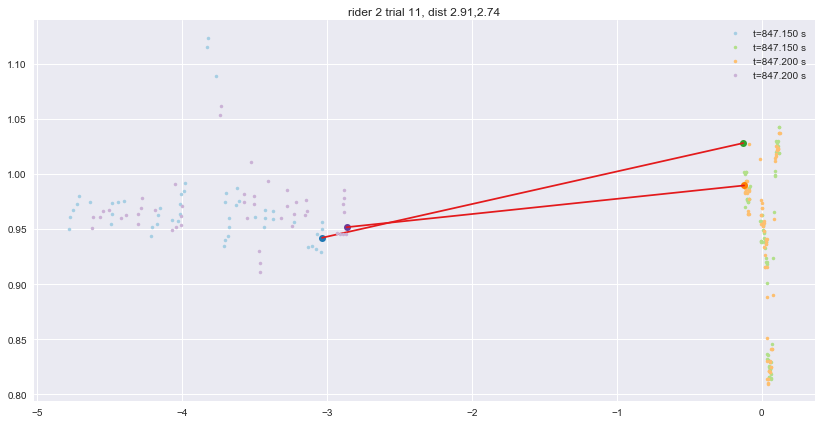

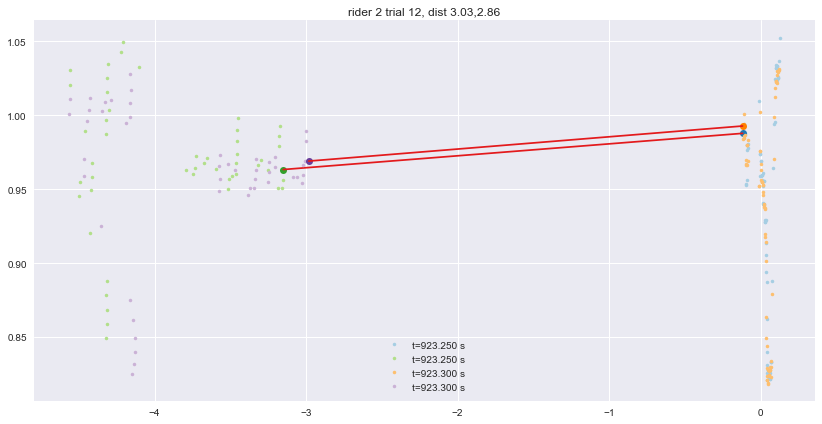

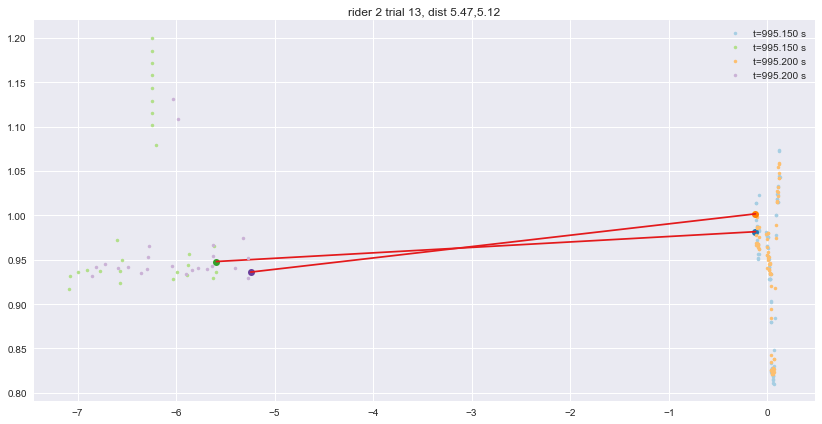

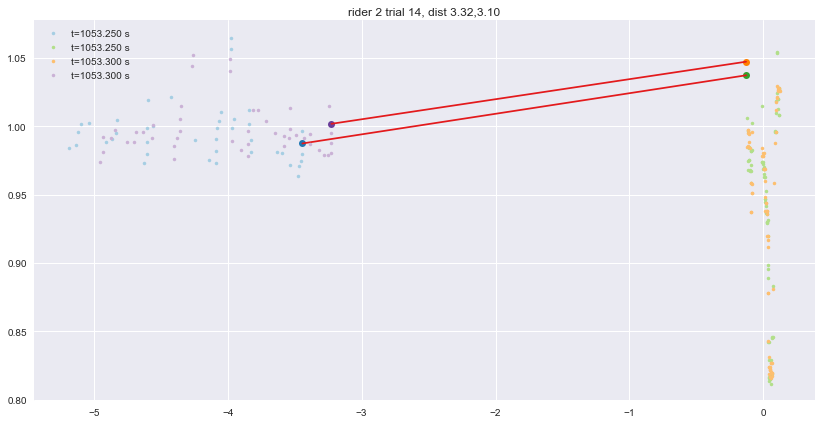

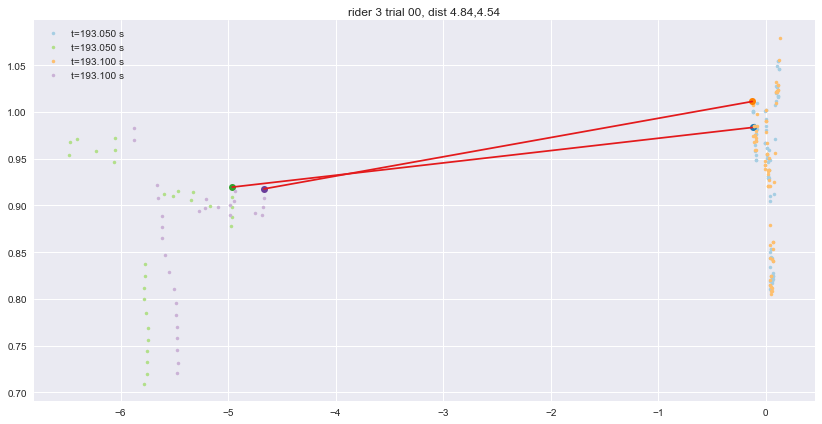

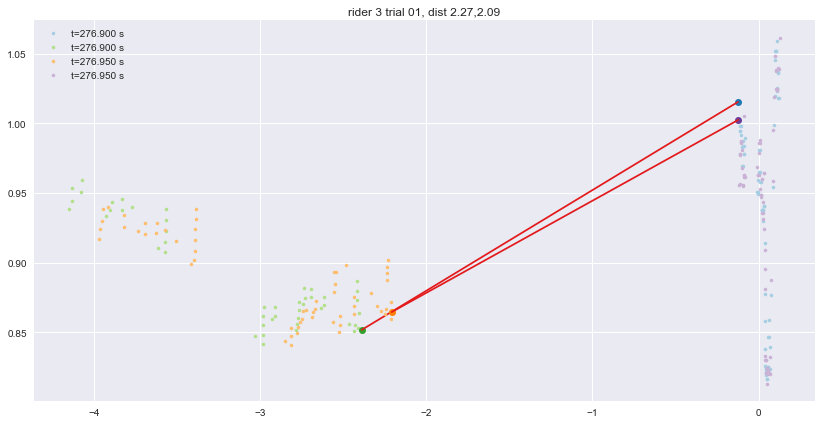

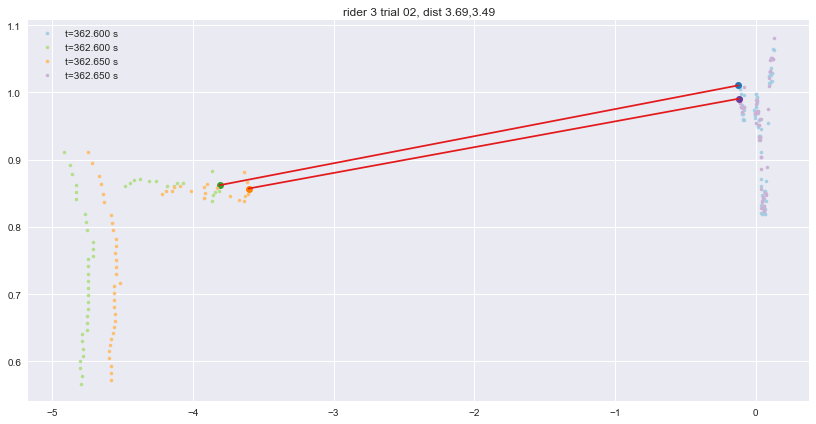

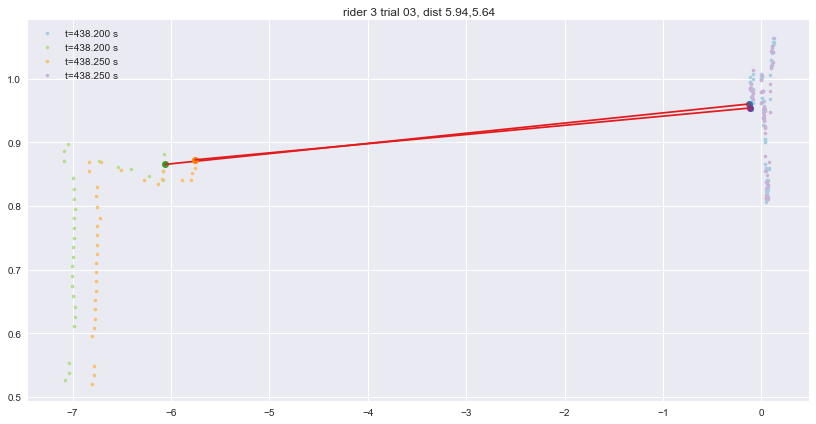

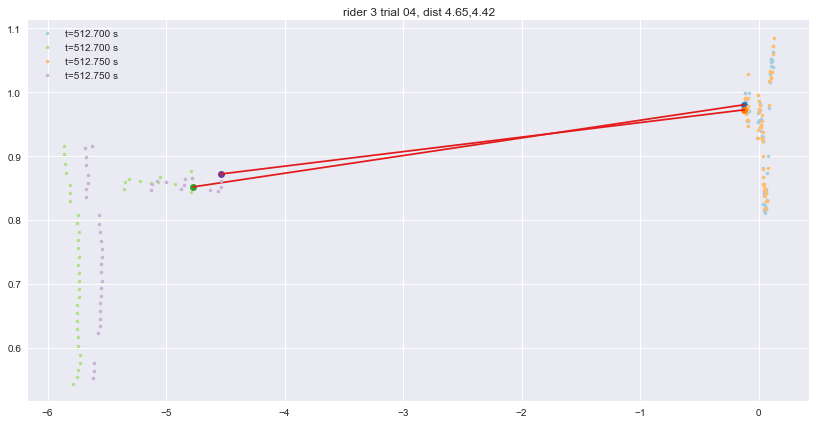

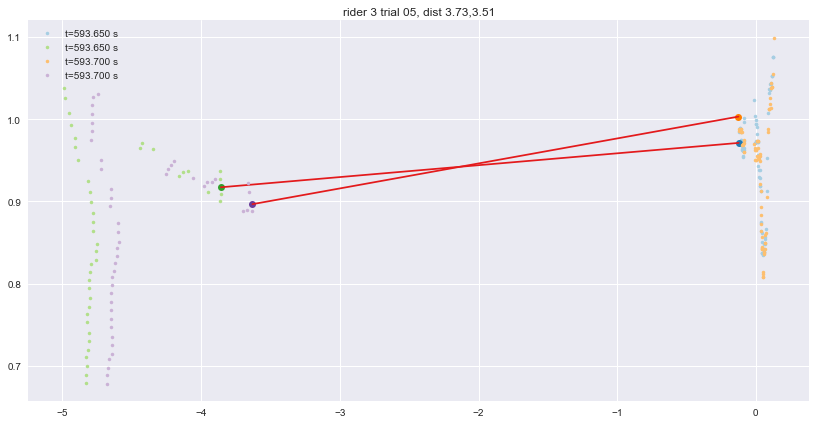

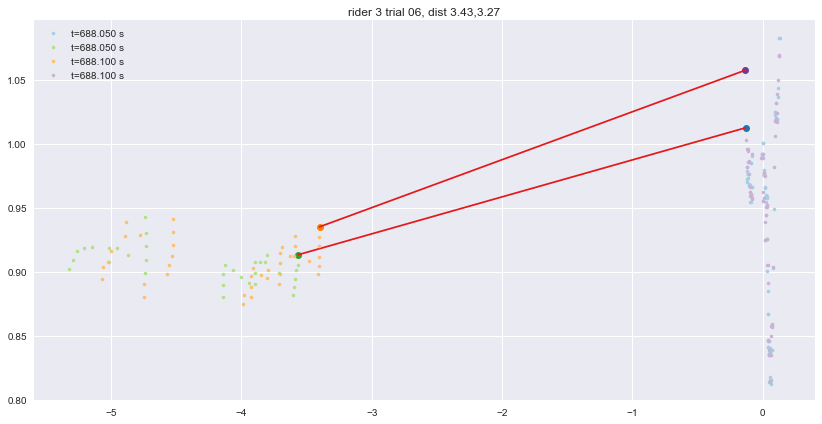

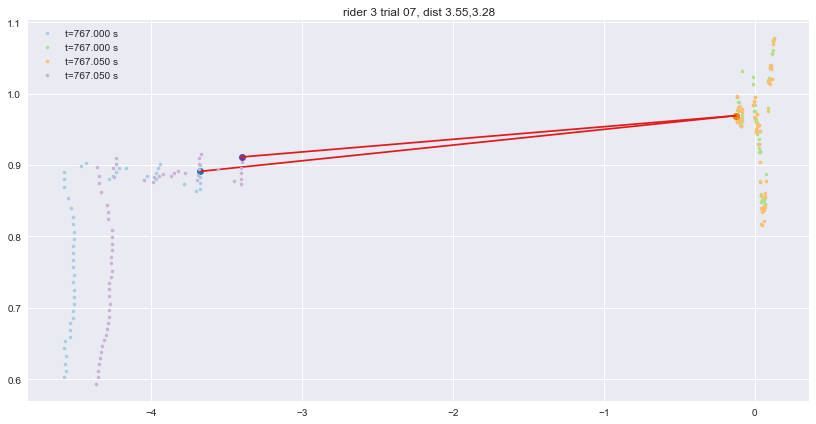

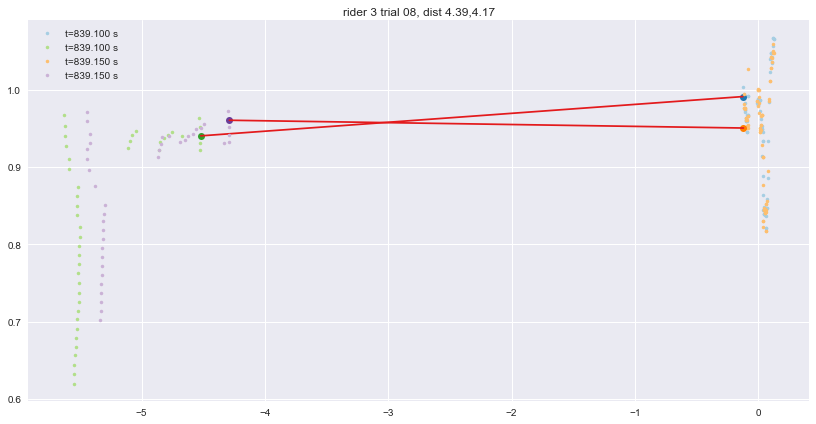

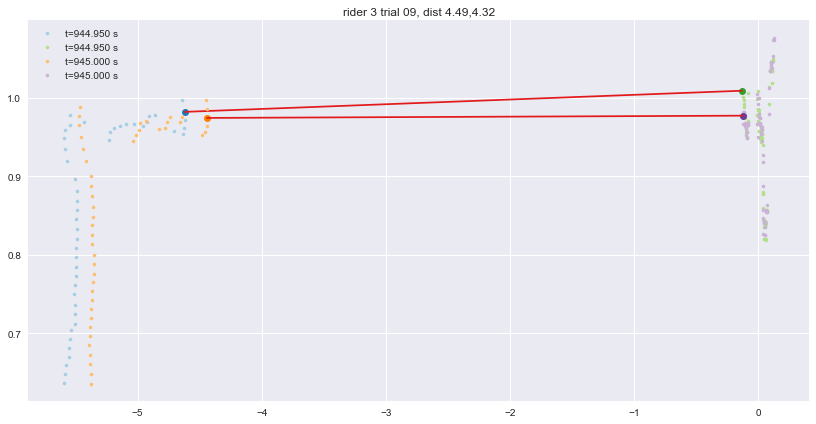

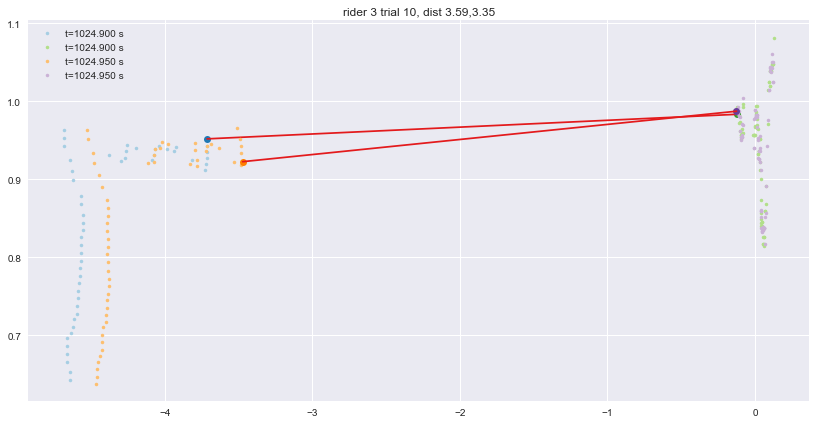

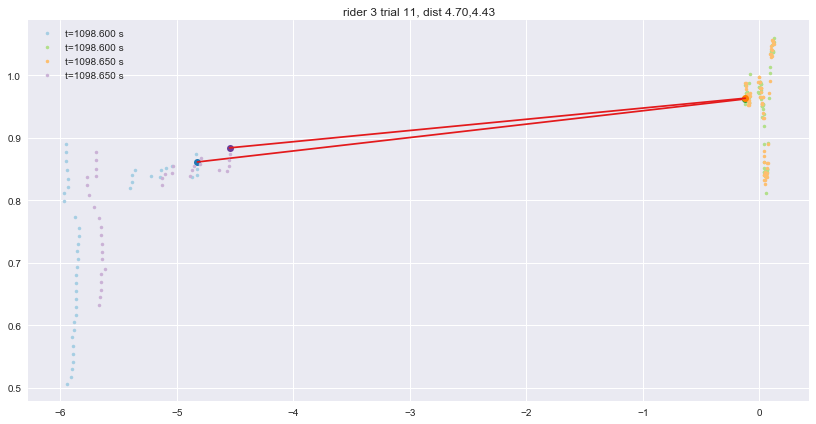

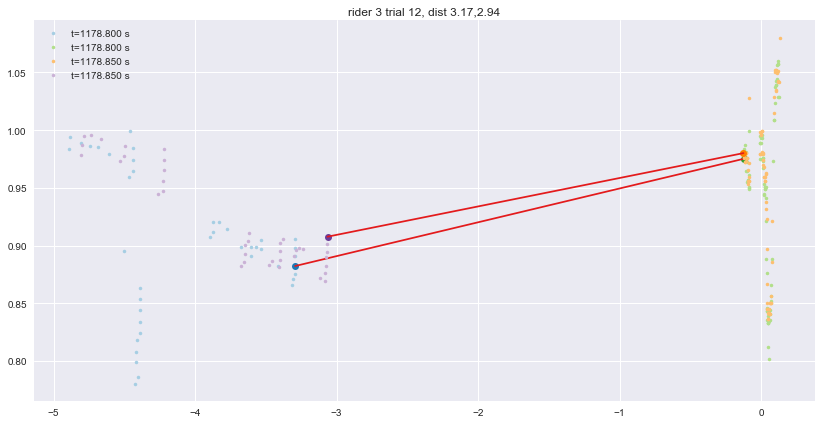

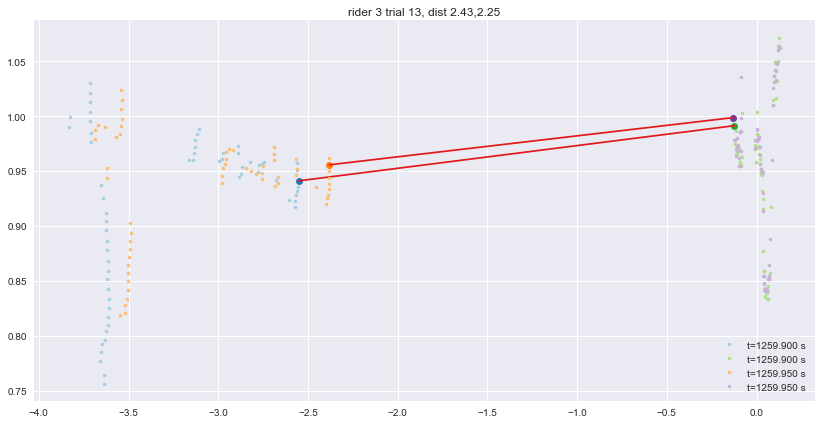

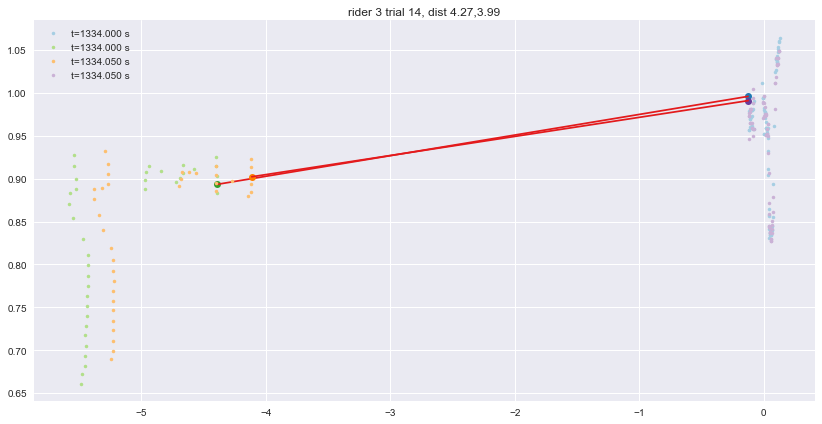

In [5]:
import seaborn as sns

# rider, trial, speed, dist1, dist2, dist_interp
data = np.zeros((4*15, 6))

plt.close()
for rid, tid in itertools.product(range(4), range(15)):
    if (rid == 0) and (tid == 1):
        data[rid*15 + tid, :] = np.array([rid, tid, np.nan, np.nan, np.nan, np.nan])
        continue
        
    record = records[rid]
    trial = record.trial[tid]
    
    _, (ev_time, _, _), ev = trial.steer_event_parameters()
    index = record.lidar.frame_index(ev_time[0])
    
    # get index before time 0
    index = np.insert(index, 0, index[0] - 1)
    
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    colors = sns.color_palette('Paired', 10)
    dist = []
    for i, c in zip(index, [0, 6]):
        frames = record.lidar[[i]]
        x, y = frames.cartesian(xlim=(-19, 1),
                                ylim=(0.5, 3))
        
        # get clusters
        a, b = cluster(x, y)
        
        # calculate minumum distance
        # TODO: account for wheel radius and LIDAR height
        d, pa, pb = bcp_brute(a, b)
        pd = np.vstack((pa, pb))
    
        ax.plot(*zip(*a), '.', color=colors[c + 0],
                label='t={:0.03f} s'.format(record.lidar.time[i]))
        ax.plot(*zip(*b), '.', color=colors[c + 2],
                label='t={:0.03f} s'.format(record.lidar.time[i]))
        ax.plot(*pa, 'o', color=colors[c + 1])
        ax.plot(*pb, 'o', color=colors[c + 3])
        ax.plot(*zip(*pd), color=colors[5])
        dist.append(d)
    
    ax.legend()
    #ax.set_xlim((-14, 1))
    #ax.set_ylim((0.5, 1.5))
    ax.set_title('rider {} trial {:02d}, dist {}'.format(
        rid, tid, ','.join('{:0.02f}'.format(d) for d in dist)))
    
    dt = record.lidar.time[index[0]] - record.lidar.time[index[-1]]
    dist_interp = (ev_time[0] - record.lidar.time[index[-1]])/dt*(dist[0] - dist[-1]) + dist[-1]
    data[rid*15 + tid, :] = np.array([rid, tid, ev.speed, dist[0], dist[-1], dist_interp])
    
plt.show()

In [6]:
import pandas as pd
from antlia.plotdf import plotjoint
colors = sns.color_palette()

# remove rows with nan
index = np.where(np.any(np.isnan(data), axis=1))[0]
data = np.delete(data, index, axis=0)

# Average speed (v) in this dataframe is over the
# steer avoidance event (infl, min, infl, max, infl, min, infl)
# and not just the sinusoid fit region (infl, min, infl)
df = pd.DataFrame(data=data, columns=['rider', 'trial', 'v', 'd1', 'd2', 'di'])

df['t1'] = df.apply(lambda row: row.d1/row.v, axis=1)
df['t2'] = df.apply(lambda row: row.d2/row.v, axis=1)
df['ti'] = df.apply(lambda row: row.di/row.v, axis=1)
print(df)

    rider  trial         v         d1         d2         di         t1  \
0     0.0    0.0  0.294541   3.261250   3.110582   3.177190  11.072318   
1     0.0    2.0  6.022226  10.043523   9.785744   9.838382   1.667743   
2     0.0    3.0  4.016655   2.931695   2.752570   2.897776   0.729885   
3     0.0    4.0  5.368322   5.347680   5.116617   5.320816   0.996155   
4     0.0    5.0  5.994924   4.713290   4.420386   4.553382   0.786214   
5     0.0    6.0  4.567633   4.540185   4.293193   4.323005   0.993991   
6     0.0    7.0  5.189857   4.540644   4.274900   4.401065   0.874907   
7     0.0    8.0  6.206539   6.002774   5.673217   5.985420   0.967169   
8     0.0    9.0  4.198477   5.416400   5.200622   5.335181   1.290087   
9     0.0   10.0  5.559790   4.131030   3.893611   4.064961   0.743019   
10    0.0   11.0  6.314231   5.311269   5.017478   5.311099   0.841159   
11    0.0   12.0  4.550632   3.230887   3.047451   3.103487   0.709986   
12    0.0   13.0  5.537313   5.611388 

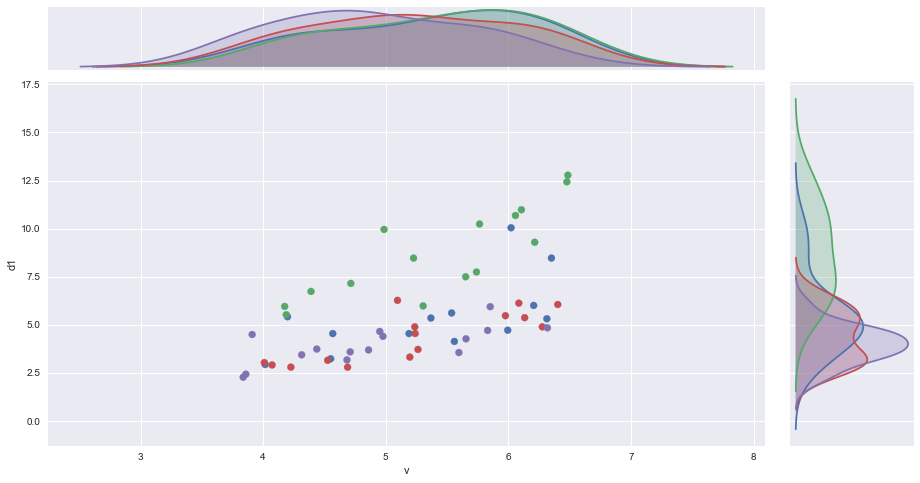

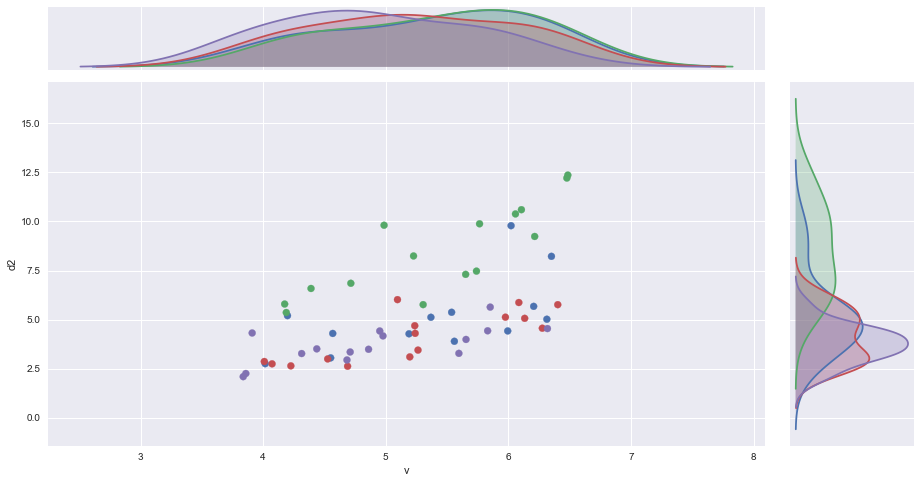

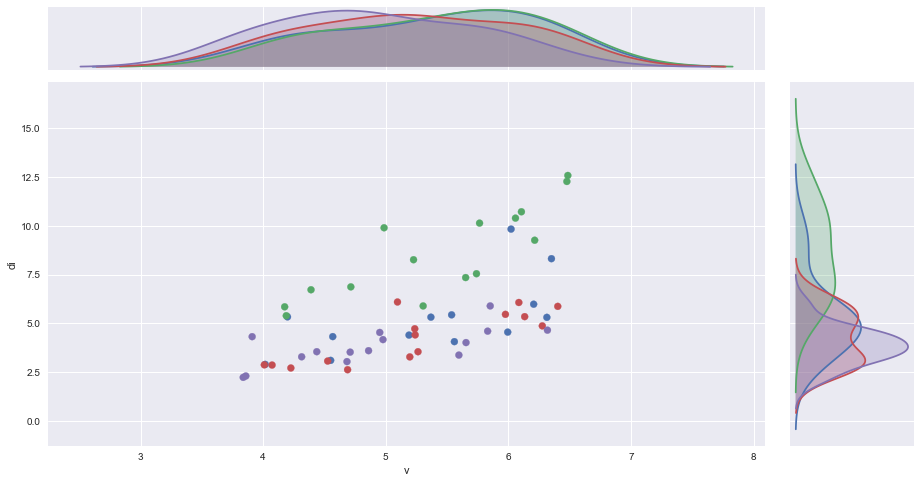

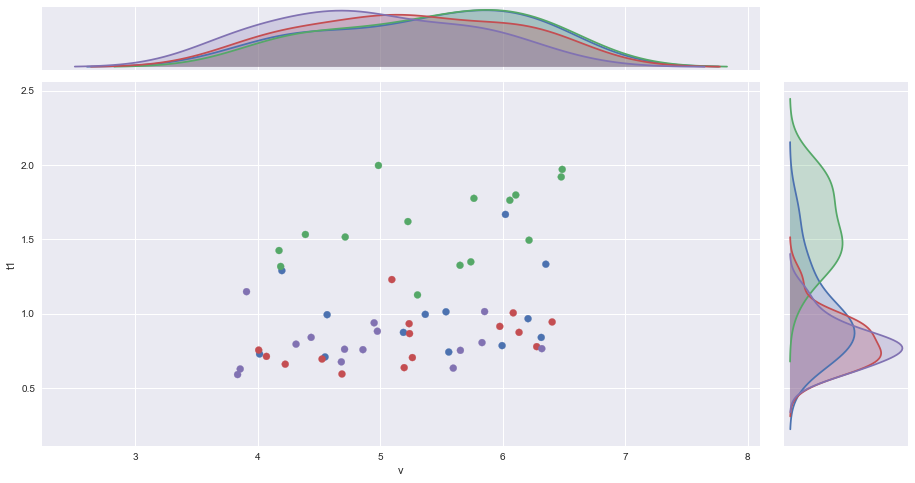

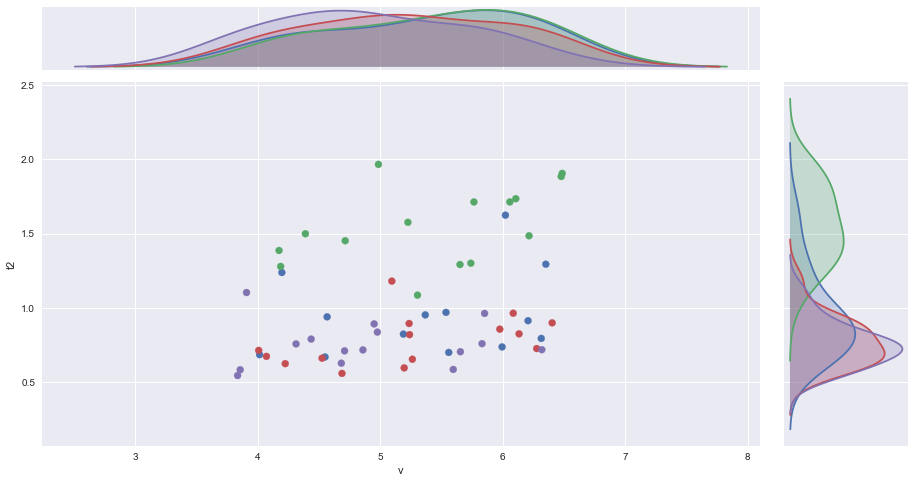

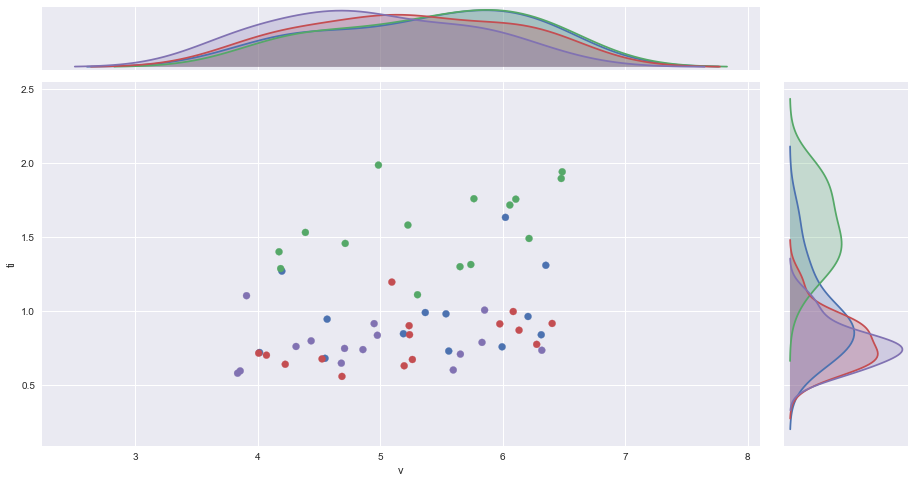

In [7]:
plt.close()
# exclude trial without working velocity sensor
g = plotjoint('v', 'd1', df[df.v > 1], ('rider', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)

# exclude trial without working velocity sensor
g = plotjoint('v', 'd2', df[df.v > 1], ('rider', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)

# exclude trial without working velocity sensor
g = plotjoint('v', 'di', df[df.v > 1], ('rider', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)

# exclude trial without working velocity sensor
g = plotjoint('v', 't1', df[df.v > 1], ('rider', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)

# exclude trial without working velocity sensor
g = plotjoint('v', 't2', df[df.v > 1], ('rider', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)

# exclude trial without working velocity sensor
g = plotjoint('v', 'ti', df[df.v > 1], ('rider', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)
plt.show()

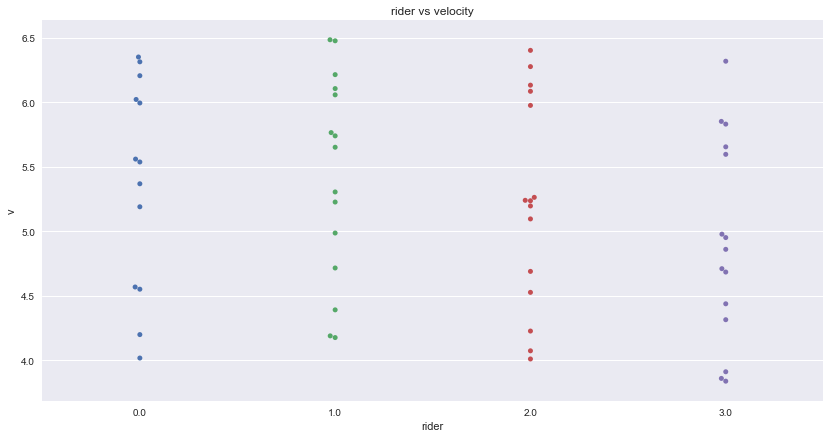

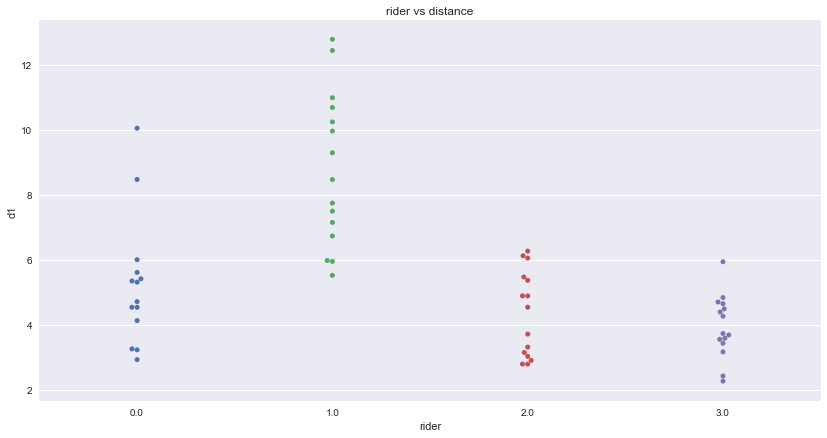

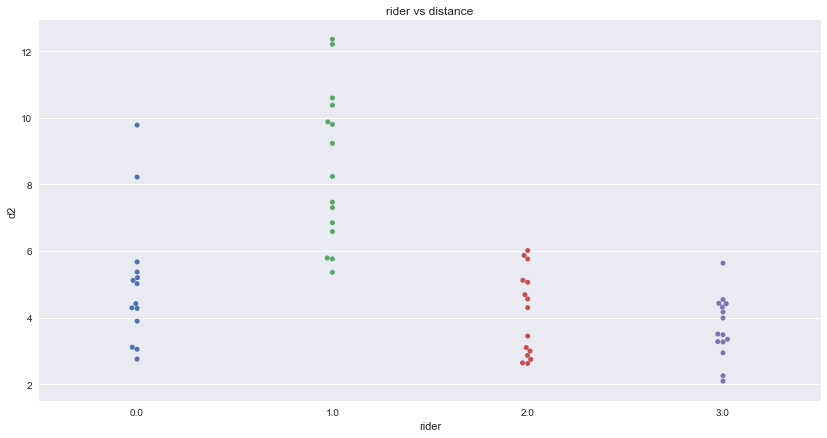

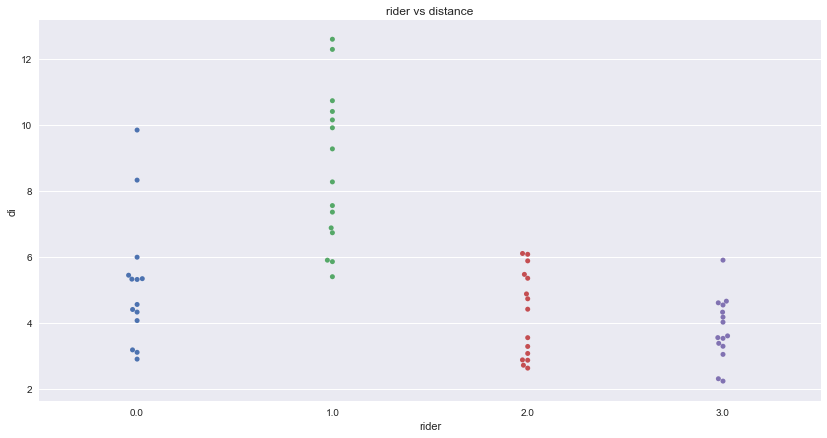

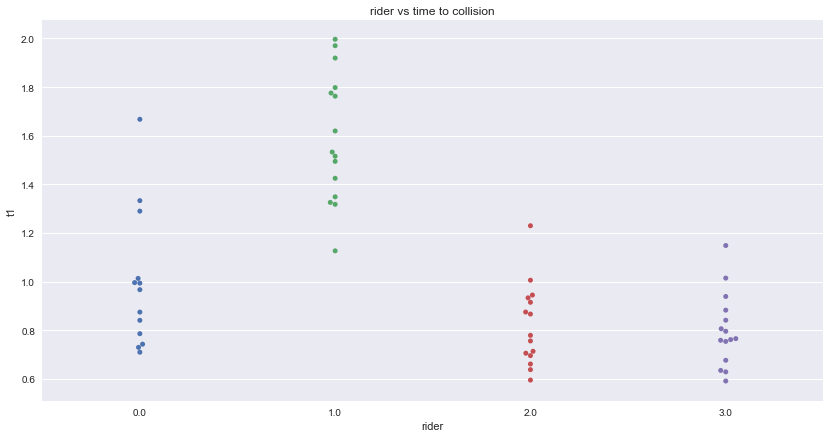

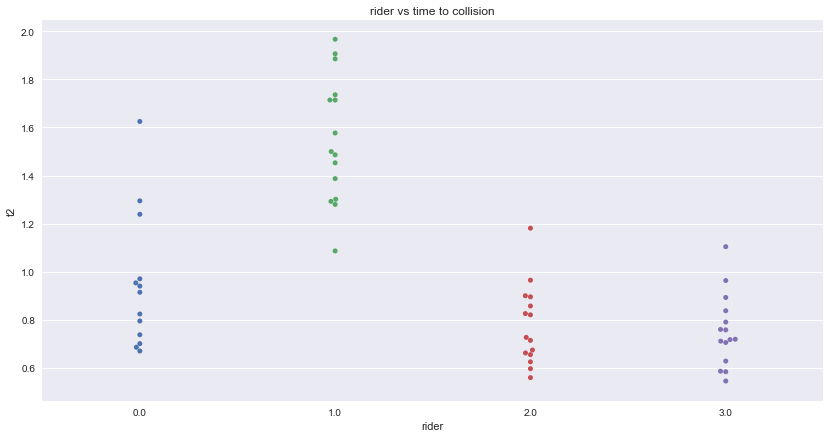

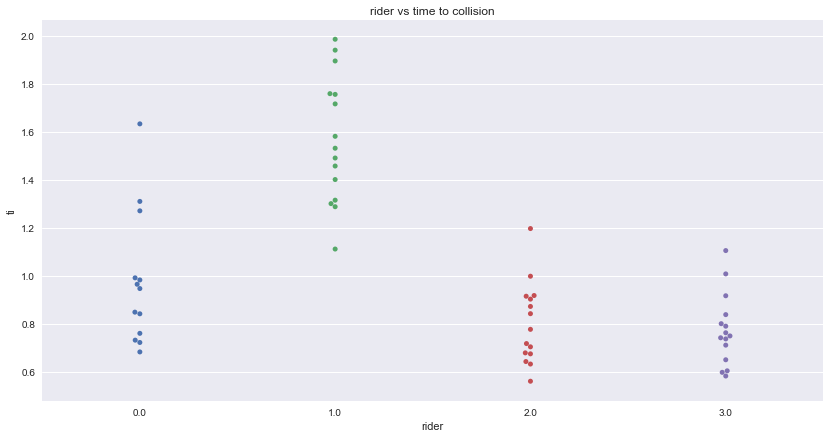

In [8]:
%matplotlib inline
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
# exclude trial without working velocity sensor
sns.swarmplot(x='rider', y='v', data=df[df.v > 1], ax=ax)
ax.set_title('rider vs velocity')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='d1', data=df, ax=ax)
ax.set_title('rider vs distance')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='d2', data=df, ax=ax)
ax.set_title('rider vs distance')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='di', data=df, ax=ax)
ax.set_title('rider vs distance')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='t1', data=df[df.v > 1], ax=ax)
ax.set_title('rider vs time to collision')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='t2', data=df[df.v > 1], ax=ax)
ax.set_title('rider vs time to collision')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='ti', data=df[df.v > 1], ax=ax)
ax.set_title('rider vs time to collision')
plt.show()